In [119]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
np.random.seed(555)
import pystan

In [103]:
stan_code = """

data {
    int N;
    real alpha;
    int Y[N];
}

parameters {
    real lambda1;
    real lambda2;
    real<lower=0, upper=70> tau;
}

model {
    tau ~ uniform(0, 70);
    for (n in 1:N) {
        if(n < tau){
            lambda1 ~ exponential(alpha);
            Y[n] ~ poisson(lambda1);
        } else {
            lambda2 ~ exponential(alpha);
            Y[n] ~ poisson(lambda2);
        }
    }
}
"""

In [96]:
import pandas as pd
from urllib.request import urlretrieve

# urlretrieve('https://git.io/vXTVC', '../data/message_cnt.csv')
message_data = np.loadtxt('../data/message_cnt.csv')

(0, 74)

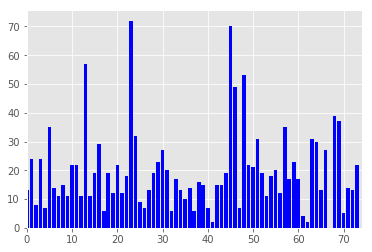

In [97]:
n_count_data = len(message_data)
plt.bar(np.arange(n_count_data), message_data, color='b')

plt.xlim(0, n_count_data)

In [104]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c86f958775592d38688a3095d7d5afb9 NOW.


In [105]:
stan_data = {
    'N': n_count_data,
    'alpha': 1./message_data.mean(),
    'Y': message_data.astype('i')
}

op = stan_model.optimizing(data=stan_data)
init_params = {'tau': op.get('tau'), 'lambda1': op.get('lambda1'), 'lambda2': op.get('lambda2')}
init_list = [init_params]*4
fit = stan_model.sampling(data=stan_data, init=init_list, iter=3000, chains=4, seed=555, thin=1, warmup=300, n_jobs=-1)
fit

C:\Users\sh70k\Anaconda3\envs\stan_env\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_c86f958775592d38688a3095d7d5afb9.
4 chains, each with iter=3000; warmup=300; thin=1; 
post-warmup draws per chain=2700, total post-warmup draws=10800.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda1  16.78    0.12   0.75  15.54  16.24  16.76  17.28  18.12     37   1.11
lambda2  21.54    0.16   0.96  19.26  21.02  21.54  22.17  23.39     38   1.09
tau      43.35    1.69   6.74  11.39  44.17  44.89  45.45  45.94     16   1.23
lp__    2836.9    0.43   2.12 2829.3 2836.5 2837.5 2838.1 2838.7     24   1.14

Samples were drawn using NUTS at Sat Feb  3 22:23:33 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

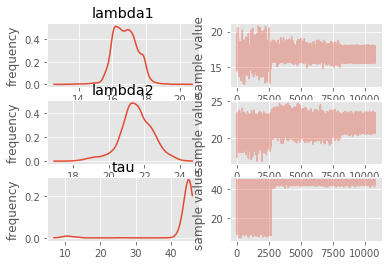

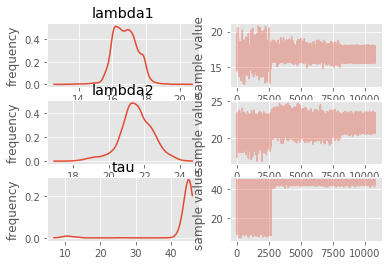

In [106]:
fit.plot()

In [107]:
samples = fit.extract()

tau: 10
16.783150730652608 21.54291801841229


<Container object of 74 artists>

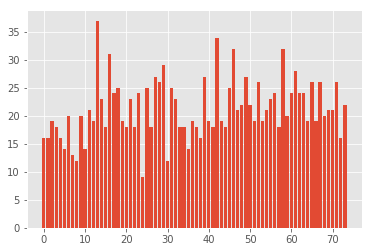

In [118]:
tau = np.random.randint(0, 70)
print('tau:', tau)
print(samples['lambda1'].mean(), samples['lambda2'].mean())
s1 = np.random.poisson(samples['lambda1'].mean(), tau)
s2 = np.random.poisson(samples['lambda2'].mean(), n_count_data-tau)
res = np.r_[s1, s2]
plt.bar(range(len(res)), res)

In [109]:
samples['lambda1']

array([17.76135759, 16.43428878, 14.41587726, ..., 17.7835641 ,
       18.02977831, 16.29223631])